# NLP to Detect Disaster Tweets

## Importing the libraries

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
import gensim
from gensim.models import Word2Vec

## Study the dataset

In [2]:
train_dataset=pd.read_csv('train.csv')
test_dataset=pd.read_csv('test.csv')

In [3]:
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Cleaning the dataset

In [4]:
#cleaning the data
train_dataset.pop('keyword')
train_dataset.pop('location')
train_dataset.head()

#cleaning the test data
test_dataset.pop('keyword')
test_dataset.pop('location')
test_dataset.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
#checking for na values
train_dataset.isna().sum()

test_dataset.isna().sum()

id      0
text    0
dtype: int64

In [6]:

print(f"The tran dataset has {train_dataset.shape[0]} rows and {train_dataset.shape[1]} columns")
print(f"The test dataset has {test_dataset.shape[0]} rows and {test_dataset.shape[1]} columns")


The tran dataset has 7613 rows and 3 columns
The test dataset has 3263 rows and 2 columns


In [7]:
#checking for duplicates
print (f"the number of duplicated value in train dataset={train_dataset.duplicated().sum()}")
print (f"the number of duplicated value in test dataset={test_dataset.duplicated().sum()}")

the number of duplicated value in train dataset=0
the number of duplicated value in test dataset=0


<Axes: xlabel='target', ylabel='Count'>

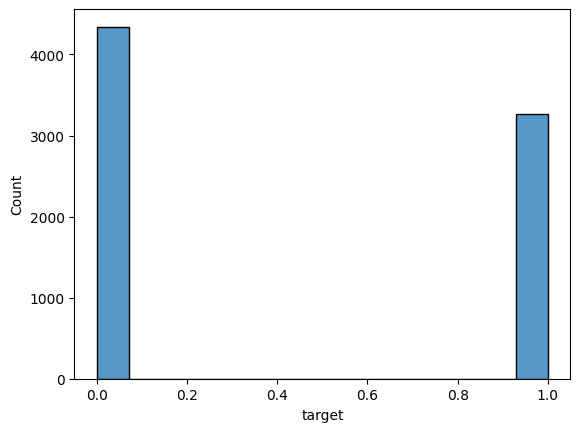

In [8]:
sns.histplot(train_dataset['target'])

## Preprocessing the dataset

In [9]:
X=train_dataset['text'].to_numpy()
Y=train_dataset['target'].to_numpy()

In [10]:
X

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [11]:
X.shape,Y.shape

((7613,), (7613,))

In [12]:
stopwords=stopwords.words('english')
ps=PorterStemmer()

In [13]:
for i in range(len(X)):
    words=word_tokenize(X[i])
    words=[word.lower() for word in words if word.isalpha()]#removing punctuations
    words=[word for word in words if word not in stopwords]
    words=[word for word in words if word not in ['http','https','co','amp']]
    words=[ps.stem(word) for word in words]
    X[i]=' '.join(words)

In [14]:
cv=CountVectorizer(max_features=5000)
X_tokenized=cv.fit_transform(X)


### Splitting the dataset into the Training set and Test set

In [15]:
x_train,x_test,y_train,y_test=train_test_split(X_tokenized,Y,test_size=0.2,random_state=42)

## Train the Models

In [16]:
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

### SVM model

In [52]:
param = {
"kernel": ["linear", "poly", "sigmoid"],
"degree": [1,2,3,4],
"gamma": ["scale"],
"coef0": range(1, 4),
"tol": [1e-5, 1e-6]
}
brain = SVC()
grained_brain = GridSearchCV(brain, param_grid=param)
grained_brain.fit(x_train, y_train)
pred=grained_brain.predict(x_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))


[[777  97]
 [195 454]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.82      0.70      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523



### Decsion tree Classifier

In [54]:
from sklearn.tree import DecisionTreeClassifier

param = {
"criterion": ["gini", "entropy"],
"splitter": ["best", "random"],
"max_depth": range(1, 15),
"min_samples_split": range(3, 7),
"min_samples_leaf": range(2, 7)
}
brain = DecisionTreeClassifier()
grained_brain = GridSearchCV(brain, param_grid=param)
grained_brain.fit(x_train, y_train)
pred=grained_brain.predict(x_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))


[[835  39]
 [449 200]]
              precision    recall  f1-score   support

           0       0.65      0.96      0.77       874
           1       0.84      0.31      0.45       649

    accuracy                           0.68      1523
   macro avg       0.74      0.63      0.61      1523
weighted avg       0.73      0.68      0.64      1523



# Gradian Boosting Classifier

In [23]:
brain = GradientBoostingClassifier()
param = {
"loss": ["log_loss", "exponential"],
"learning_rate": [0.1, 0.05, 0.01],
"n_estimators": [100, 150, 200],
"max_depth": range(1, 5),
"criterion" : ["friedman_mse", "mse", "mae"]
}
grained_brain = GridSearchCV(brain, param_grid=param)
grained_brain.fit(x_train, y_train)
pred=grained_brain.predict(x_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))



c:\Users\Ebrah\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ebrah\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ebrah\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "c:\Users\Ebrah\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py",

[[774 100]
 [236 413]]
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       874
           1       0.81      0.64      0.71       649

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523



# Test the Models

In [33]:
def prepare(str): 
    words=word_tokenize(str)
    words=[word.lower() for word in words if word.isalpha()]#removing punctuations
    words=[word for word in words if word not in stopwords]
    words=[word for word in words if word not in ['http','https','co','amp']]
    words=[ps.stem(word) for word in words]
    X=' '.join(words)
    return [X]

In [37]:
# make happy prediction
example = ["I am very happy today! The atmosphere looks stormy though"]
example = prepare(example[0])
example = cv.transform(example).toarray()
print(grained_brain.predict(example))

# make diasater prediction
diaster_tweet = ["There is a fire in the building"]
diaster_tweet = prepare(diaster_tweet[0])
diaster_tweet = cv.transform(diaster_tweet).toarray()
print(grained_brain.predict(diaster_tweet))

[0]
[1]
